In [1]:
import tensorflow as tf
devices = tf.config.list_physical_devices('GPU')

print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(devices))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


In [2]:
# tensorflow version
print(tf.__version__)

2.19.0


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import kagglehub

# dataset
path = kagglehub.dataset_download("khoongweihao/covid19-xray-dataset-train-test-sets")

Using Colab cache for faster access to the 'covid19-xray-dataset-train-test-sets' dataset.


In [15]:
#importing dataset
print("Files and folders in dataset:")
print(os.listdir(path))
train_data = path+"/xray_dataset_covid19/train"
test_data = path+ "/xray_dataset_covid19/test"

Files and folders in dataset:
['xray_dataset_covid19']


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)  # pixel value normalization
test_datagen = ImageDataGenerator(

)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(256, 256),  # Resize images to a common size
    batch_size=32,           # Number of images to process in a batch
    class_mode='binary'
)

# Load testing data
test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)


x_train, y_train = next(train_generator) # Use next(train_generator) to get the next batch
x_test, y_test = next(test_generator)   # Use next(test_generator) to get the next batch

x_train=x_train/255
x_test=x_test/255

Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


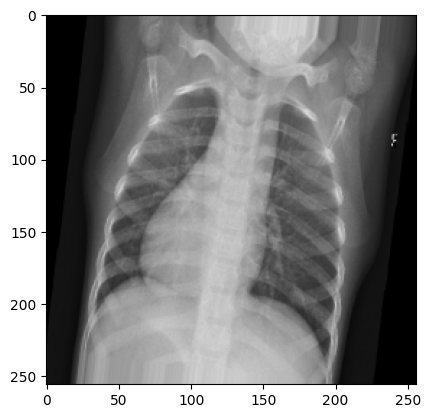

In [19]:
x_train.shape,y_train.shape
y_train.min(),y_train.max()
plt.imshow(x_train[0])

In [20]:
y_train[0]

np.float32(0.0)

In [21]:
# Reshape images from 3D (height, width, channels) to 2D (pixels, channels) for LSTM processing
img_height = x_train.shape[1]
img_width = x_train.shape[2]
x_train_flat = x_train.reshape((x_train.shape[0], img_height * img_width, 3))  # Flatten spatial dimensions but keep channels
x_test_flat = x_test.reshape((x_test.shape[0], img_height * img_width, 3))

# Define LSTM model architecture
model = tf.keras.Sequential()

# First LSTM layer processes the sequence of pixels
model.add(tf.keras.layers.LSTM(units=64, activation='relu', return_sequences=True,
                              input_shape=(x_train_flat.shape[1], x_train_flat.shape[2])))
model.add(tf.keras.layers.Dropout(0.3))  # Dropout to prevent overfitting
model.add(tf.keras.layers.BatchNormalization())  # Normalize activations for stable training

# Second LSTM layer for deeper sequence understanding
model.add(tf.keras.layers.LSTM(units=64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.BatchNormalization())

# Dense layer to interpret LSTM features
model.add(tf.keras.layers.Dense(units=32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))

# Output layer for binary classification (sigmoid for 0-1 probability)
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Configure model training with gradient clipping for stability
opt = tf.keras.optimizers.Adam(learning_rate=1e-5, clipvalue=1.0)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Display model architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 65536, 64)      │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 65536, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 65536, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,057 (207.25 KB)

 Trainable params: 52,801 (206.25 KB)

 Non-trainable params: 256 (1.00 KB)

In [22]:
history = model.fit(x_train_flat, y_train, epochs=20, batch_size=4, validation_data=(x_test_flat, y_test))

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 91s 10s/step - accuracy: 0.4092 - loss: 0.8755 - val_accuracy: 0.8438 - val_loss: 0.6808
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 78s 10s/step - accuracy: 0.5667 - loss: 0.6754 - val_accuracy: 0.7500 - val_loss: 0.6824
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 10s/step - accuracy: 0.4284 - loss: 0.7896 - val_accuracy: 0.7188 - val_loss: 0.6856
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 10s/step - accuracy: 0.5545 - loss: 0.8140 - val_accuracy: 0.5938 - val_loss: 0.6893
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 10s/step - accuracy: 0.3448 - loss: 0.8307 - val_accuracy: 0.4062 - val_loss: 0.6922
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 10s/step - accuracy: 0.3599 - loss: 0.8578 - val_accuracy: 0.4062 - val_loss: 0.6941
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 10s/step - accuracy: 0.4664 - loss: 0.7143 - val_accuracy: 0.4062 - val_loss: 0.6961
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 10s/step - accuracy: 0.5046 - loss: 0.8291 - val_accuracy: 0.4062 - val_loss: 0.6970


In [23]:
#confusion metrix
from sklearn.metrics import confusion_matrix,accuracy_score
confusion = confusion_matrix(y_test, y_train)
print(confusion)

[[ 8  5]
 [12  7]]


In [24]:
acc_cm = accuracy_score(y_test, y_train)
print(acc_cm)

0.46875


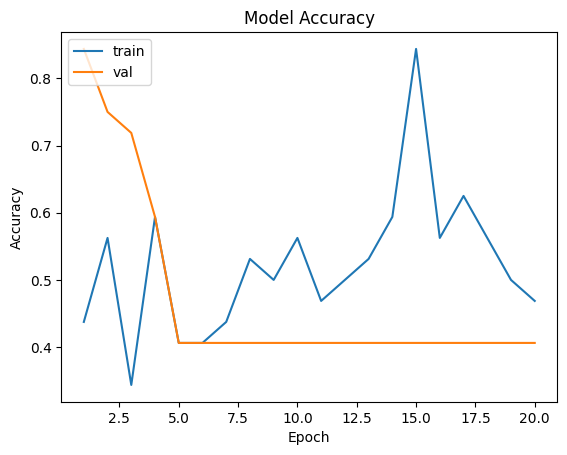

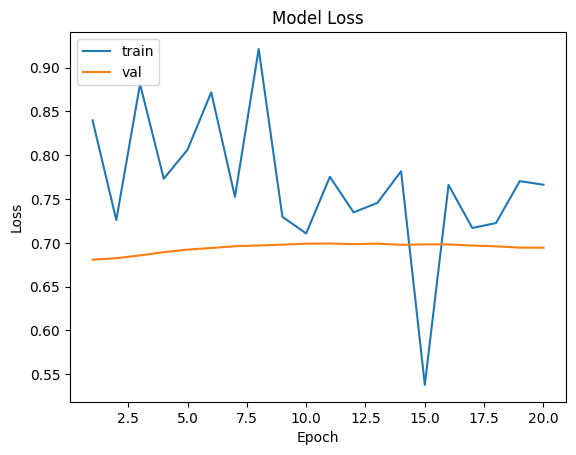

In [25]:
#learning curve
def learning_curve(history,epoch):

  #training vs validation accuracy
  epoch_range = range(1,epoch+1)
  plt.plot(epoch_range,history.history['accuracy'])
  plt.plot(epoch_range,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train','val'],loc='upper left')
  plt.show()

  # traning vs validation loss
  plt.plot(epoch_range,history.history['loss'])
  plt.plot(epoch_range,history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train','val'],loc='upper left')
  plt.show()

learning_curve(history,20)

In [26]:
from sklearn.metrics import f1_score


scoreforF1 = f1_score(y_test, y_train)

print(f'F1 Score: {scoreforF1:.4f}')

F1 Score: 0.4516


In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_train))

              precision    recall  f1-score   support

         0.0       0.40      0.62      0.48        13
         1.0       0.58      0.37      0.45        19

    accuracy                           0.47        32
   macro avg       0.49      0.49      0.47        32
weighted avg       0.51      0.47      0.47        32

